In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import math
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [ ]:
# ВИЗУАЛИЗАЦИЯ

def visualization(models, x_train, y_train):
  X=np.array(x_train)
  y=y_train
  h = 3 # шаг в сетке

  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Рисуем границы принятия решений на графике

  Z = models.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Set1, alpha=0.8)

  # Рисуем точки данных
  plt.scatter(X[:, 0], X[:, 1], c=y,cmap=plt.cm.Set1,  edgecolor='k')
  #plt.show()

In [ ]:
# ВИЗУАЛИЗАЦИЯ ДЛЯ SMO

def visualizationSMO(models, x_train, y_train):
  X=np.array(x_train)
  y=y_train
  h = 1  # шаг в сетке

  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Создаем график
  #plt.figure(figsize=(12, 8))

  # Рисуем границы принятия решений на графике

  Z = np.sign(models.predict(np.c_[xx.ravel(), yy.ravel()]))
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Set1, alpha=0.8)

  # Рисуем точки данных
  plt.scatter(X[:, 0], X[:, 1], c=y,cmap=plt.cm.Set1,  edgecolor='k')

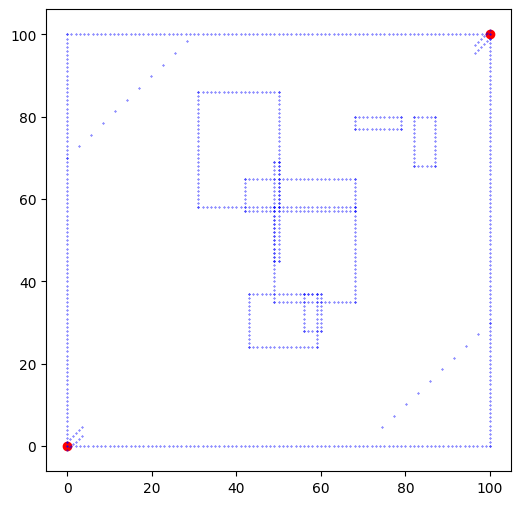

In [ ]:
# ГЕНЕРАЦИЯ ПРЕПЯТСТВИЙ

intial=np.array([0,0]) # начальная точка
finish=np.array([100,100]) # конечная точка
koef=(finish[1]-intial[1])/(finish[0]-intial[0])
b=intial[1]-koef*intial[0]
guide_vector=(finish-intial)/np.linalg.norm(finish-intial) # вектор коллиниарный прямой соединяющий начал. и конеч. точки

# граница "квадрат"
bord=np.arange(0,100.1,1)
x_bord=np.hstack([bord,np.zeros(len(bord)),np.full(len(bord),100),bord])
y_bord=np.hstack([np.zeros(len(bord)),bord,bord,np.full(len(bord),100)])
lb=[]
for i in range(len(x_bord)):
  if(x_bord[i] < y_bord[i]):
    lb.append(1)
  else:
    lb.append(-1)
label_bord=np.array(lb)

# ПРЕПЯТСТВИЯ

n=8 # Количество препятствий
X=np.array([])
Y=np.array([])
number=np.array([])
vertic=[]
new_number=1
for i in range(n):
  #случайно выбираем координаты нижней левой точки
  vertx=np.random.randint(5,94)
  verty=np.random.randint(max(5,vertx-30),min(94, vertx+30))
  #случайно выбираем координаты правой верхней точки
  vertx2=np.random.randint(vertx+1,min(vertx+30,95))
  verty2=np.random.randint(verty+1,min(verty+30,95))

  obstx=np.arange(vertx,vertx2,1)
  obsty=np.arange(verty,verty2,1)
  X_add=np.hstack([obstx,np.full(len(obsty),int(obstx[0])),np.full(len(obsty),int(obstx[-1])),obstx])
  X=np.append(X,X_add)
  Y_add=np.hstack([np.full(len(obstx),int(obsty[0])),obsty,obsty,np.full(len(obstx),int(obsty[-1]))])
  Y=np.append(Y,Y_add)

  flag=True # not intersect
  for k in range(i):
    if(i==0):
      break
    got=((vertx<vertic[k][0]) and (verty<vertic[k][1]) and (vertx2>vertic[k][2]) and (verty2>vertic[k][3]))
    got2=((vertx>vertic[k][0]) and (verty>vertic[k][1]) and (vertx2<vertic[k][2]) and (verty2<vertic[k][3]))
    pere= (max(vertx, vertic[k][0])<=min(vertx2,vertic[k][2])) and(max(verty,vertic[k][1])<=min(verty2,vertic[k][3]))
    if(pere or got or got2):
      #print("intersect")
      #если пересекается с предыдущим препятствием
      for j in range(X_add.shape[0]):
        number=np.append(number,vertic[k][4])
      flag=False
      break
  if(flag):
    #print("not intersect")
    for j in range(len(X_add)):
      number=np.append(number,new_number)
    new_number+=1
  vertic.append([vertx,verty,vertx2,verty2,number[-1]])


# ТОЧКИ У НАЧАЛЬНОЙ И КОНЕЧНОЙ

x0,y0=[0,0,100,100],[0,0,100,100]
y0[0]-=1
y0[1]+=1
y0[2]-=1
y0[3]+=1
label0=[-1,1,-1,1]
step=1
n=5 #количество искусственных точек сверху и снизу вокруг начал. и конеч. точек
for i in range(4*n):
  x0.append(x0[i]+((-1)**(i%4 >=2))*step*guide_vector[0])
  y0.append(y0[i]+((-1)**(i%4 >=2))*step*guide_vector[1])
  label0.append((-1)**(i%2 ==0))

# ПАРАЛЛЕЛЬНЫЕ ЛИНИИ

xp,yp=[intial[0]],[intial[1]+70]
step2=4
counter=0
labelp=[1]
for i in range(0,10,1):
  counter+=1
  xp.append(xp[i]+step2*guide_vector[0])
  yp.append(yp[i]+step2*guide_vector[1])
  labelp.append(1)
  if((xp[-1]>(finish[0])) or (yp[-1]>(finish[1]))):
    break
xp.append(finish[0])
yp.append(finish[1]-70)
labelp.append(-1)
for i in range(counter+1,counter+10,1):
  xp.append(xp[i]-step2*guide_vector[0])
  yp.append(yp[i]-step2*guide_vector[1])
  labelp.append(-1)
  if(xp[-1]<(intial[0]) or yp[-1]<(intial[1])):
    break
#(xp[-1]<finish[0] and yp[-1]<finish[1]):



# Отрисовка препятствий
plt.figure(figsize=(6,6))
plt.scatter(X,Y,s=0.1,c='blue')
plt.scatter(0,0, c='red')
plt.scatter(100,100, c='red')
plt.scatter(x0,y0,s=0.1,c='blue')
plt.scatter(x_bord,y_bord,s=0.1,c='blue')
plt.scatter(xp,yp, s=0.1, c='blue')

In [ ]:
# ПРИСВОЕНИЕ МЕТОК ПРЕПЯТСТВИЯМ

def give_label(X,Y,number):
  global koef,b
  x_train=np.array([])
  y_train=np.array([])
  label=np.array([])
  for i in np.unique(number):
    center_mass=np.array([X[number==i].mean(),Y[number==i].mean()])
    x_train=np.append(x_train,X[number==i])
    y_train=np.append(y_train,Y[number==i])
    if(koef*center_mass[0]- center_mass[1]+b >=0):
      labe=np.full(len(X[number==i]),-1)
      label=np.append(label,labe)
    else:
      labe=np.full(len(X[number==i]),1)
      label=np.append(label,labe)
  return x_train,y_train,label

x_train,y_train,labe=give_label(X,Y,number)
Xt=np.hstack([ x_bord,xp, x0,x_train])
Yt=np.hstack([ y_bord,yp, y0,y_train])
label=np.hstack([label_bord,labelp,label0,labe])

x_train=pd.DataFrame({'x':Xt,'y':Yt})

C=  10
Accuracy of RBF kernel: 0.9924160346695557


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


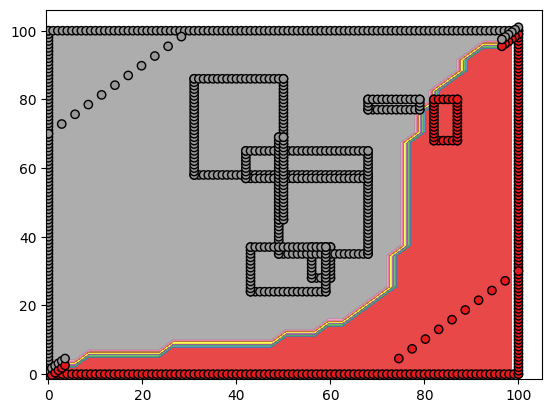

In [ ]:
#ЗАПУСК НА БИБЛИОТЕЧНОЙ РЕАЛИЗАЦИИ

rbf_svc = svm.SVC(kernel='rbf', C=10,  probability=True).fit(x_train, label)
print("C= ", 10)
print('Accuracy of RBF kernel:', accuracy_score(label, rbf_svc.predict(x_train)))
visx=np.copy(x_train)
visy=np.copy(label)
visualization(rbf_svc, visx,visy)

In [ ]:
# SVM с помощью CVXOPT

import cvxopt

class Cvxopt:
  def __init__(self,X,C=1):
    self.C=C
    n,m=X.shape
    self.W=np.array(X.shape[0])
    self.b=0
    self.sigma_sq=1
    self.initial=np.copy(X)

  def product(self,k,l): #Аналог скалярного произведения двух векторов
      return np.exp(-sum((k-l)**2)/(2*self.sigma_sq))

  def gaussian_kernel(self,x1,x2):
        m1=x2.shape[0]
        n1=x1.shape[0]
        op=[[self.product(x1[x_index],x2[l_index]) for l_index in range(m1)] for x_index in range(n1)]
        #Находит все комбинации скалярных произведений векторов-объектов
        return np.array(op)

  def fit(self,x,t):
    n_samples, n_features = x.shape
    y=np.copy(t)
    X=np.copy(x)
    #self.initial=np.copy(X)

    K=self.gaussian_kernel(X,X)

    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)
    # soft-margin SVM
    G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

    # solve QP problem
    #L(α) = - (1/2) * α^T * P * α + α^T * 1
    #0 ≤ α ≤ C
    #α^T * y = 0

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    a = np.ravel(solution['x'])

    self.W = ((y * a).T @ K)#.reshape(-1,1)

    #Selecting the set of indices S corresponding to non zero parameters
    S = (a > 1e-4).flatten()

    self.b = y[S] - np.dot(K[S], self.W)


  def predict(self,x_train):
    X=np.copy(x_train)
    init=np.copy(self.initial)
    xpr=self.gaussian_kernel(X,init)
    weight=np.copy(self.W)
    predictin = xpr.dot(weight)
    return np.where(predictin > 0, 1, -1)

  def param(self):
    return self.W,self.b

In [ ]:
# ЗАПУСК НА SVM с помощью CVXOPT

visx=np.copy(x_train)
visy=np.copy(label)
model23=Cvxopt(x_train)
model23.fit(x_train,label)
print(accuracy_score(visy,model23.predict(visx)))

967 967
(967, 967)
     pcost       dcost       gap    pres   dres
 0: -1.6572e+02 -1.4358e+03  1e+03  7e-14  4e-16
 1: -1.7119e+02 -2.6844e+02  1e+02  6e-14  3e-16
 2: -1.7396e+02 -1.8857e+02  1e+01  5e-15  1e-16
 3: -1.7457e+02 -1.7630e+02  2e+00  3e-15  1e-16
 4: -1.7470e+02 -1.7481e+02  1e-01  2e-14  1e-16
 5: -1.7471e+02 -1.7472e+02  8e-03  2e-14  1e-16
 6: -1.7471e+02 -1.7471e+02  6e-04  3e-14  1e-16
 7: -1.7471e+02 -1.7471e+02  2e-05  2e-14  1e-16
Optimal solution found.
shape W=  (967,) float64
shape b=  (935,) float64
967 967
0.9979317476732161


(967, 2)
(967,)
(967,)
967 1190


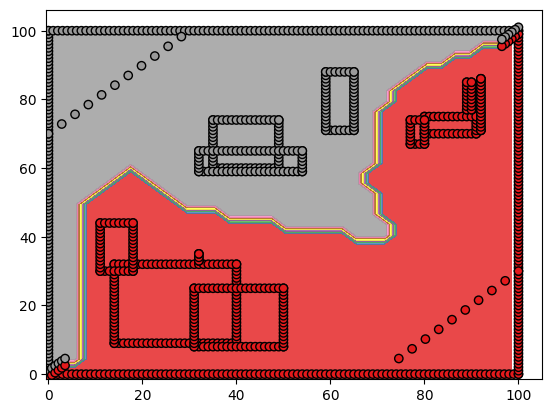

In [ ]:
print(visx.shape)
print(visy.shape)
w,b=model23.param()
print(w.shape)
visualization(model23, visx,visy)

In [ ]:
# РЕАЛИЗАЦИЯ SMO

class SMO2:
    def __init__(self, X, y, C=1, kernel='rbf', b=0, max_iter=300, tol=1e-5, eps=1e-8):
        self.X = X
        self.y = y
        self.m, self.n = np.shape(self.X)
        self.C = C
        self.alphas = np.zeros(self.m)
        self.b = b
        self.kernel = kernel
        if kernel == 'linear':
            self.kernel_func = self.linear_kernel
        elif kernel == 'gaussian' or kernel == 'rbf':
            self.kernel_func = self.gaussian_kernel

        self.error = np.zeros(self.m)
        self.max_iter=max_iter
        self.tol = tol
        self.eps = eps
        self.is_linear_kernel = True if self.kernel == 'linear' else False
        self.w = np.zeros(self.n)  # used by linear kernel

    def linear_kernel(self, x1, x2, b=0):
        return x1 @ x2.T + b

    def gaussian_kernel(self, x1, x2, sigma=1):
        gamma=0.008
        sigma=(1/(2*gamma))**(1/2)
        if np.ndim(x1) == 1 and np.ndim(x2) == 1:
            return np.exp(-(np.linalg.norm(x1-x2,2))**2/(2*sigma**2))
        elif(np.ndim(x1)>1 and np.ndim(x2) == 1) or (np.ndim(x1) == 1 and np.ndim(x2)>1):
            return np.exp(-(np.linalg.norm(x1-x2, 2, axis=1)**2)/(2*sigma**2))
        elif np.ndim(x1) > 1 and np.ndim(x2) > 1 :
            return np.exp(-(np.linalg.norm(x1[:, np.newaxis] \
                             - x2[np.newaxis, :], 2, axis = 2) ** 2)/(2*sigma**2))
        return 0.

    def predict(self, x):
        result = ((self.alphas * self.y) @ self.kernel_func(self.X, x) + self.b)
        return result

    def get_error(self, i):
        return self.predict(self.X[i,:]) - self.y[i]

    def take_step(self, i1, i2):
        if (i1 == i2):
            return 0
        x1 = self.X[i1, :]
        x2 = self.X[i2, :]
        y1 = self.y[i1]
        y2 = self.y[i2]
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        b = self.b
        E1 = self.get_error(i1)
        E2 = self.get_error(i2)
        s = y1 * y2
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)

        if L == H:
            return 0

        k11 = self.kernel_func(x1, x1)
        k12 = self.kernel_func(x1, x2)
        k22 = self.kernel_func(x2, x2)
        eta = k11 + k22 - 2 * k12
        if eta > 0:
            alpha2_new = alpha2 + y2 * (E1 - E2) / eta
            if alpha2_new >= H:
                alpha2_new = H
            elif alpha2_new <= L:
                alpha2_new = L
        else:
            # Abnormal case for eta <= 0, treat this scenario as no progress
            return 0
        # Numerical tolerance
        # if abs(alpha2_new - alpha2) < self.eps:   # this is slower
        # below is faster, not degrade the SVM performance
        if abs(alpha2_new - alpha2) < self.eps * (alpha2 + alpha2_new + self.eps):
            return 0
        alpha1_new = alpha1 + s * (alpha2 - alpha2_new)
        # Numerical tolerance
        if alpha1_new < self.eps:
            alpha1_new = 0
        elif alpha1_new > (self.C - self.eps):
            alpha1_new = self.C
        # Update threshold
        b1 = b - E1 - y1 * (alpha1_new - alpha1) * k11 - y2 * (alpha2_new - alpha2) * k12
        b2 = b - E2 - y1 * (alpha1_new - alpha1) * k12 - y2 * (alpha2_new - alpha2) * k22
        if 0 < alpha1_new < self.C:
            self.b = b1
        elif 0 < alpha2_new < self.C:
            self.b = b2
        else:
            self.b = 0.5 * (b1 + b2)
        # Update weight vector for linear SVM
        if self.is_linear_kernel:
            self.w = self.w + y1 * (alpha1_new - alpha1) * x1 \
                            + y2 * (alpha2_new - alpha2) * x2
        self.alphas[i1] = alpha1_new
        self.alphas[i2] = alpha2_new
        # Error cache update
        ## if alpha1 & alpha2 are not at bounds, the error will be 0
        self.error[i1] = 0
        self.error[i2] = 0
        i_list = [idx for idx, alpha in enumerate(self.alphas) \
                      if 0 < alpha and alpha < self.C]
        for i in i_list:
            self.error[i] += \
                  y1 * (alpha1_new - alpha1) * self.kernel_func(x1, self.X[i,:]) \
                + y2 * (alpha2_new - alpha2) * self.kernel_func(x2, self.X[i,:]) \
                + (self.b - b)
        return 1
    def examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self.get_error(i2)
        r2 = E2 * y2
        if ((r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0)):
            if len(self.alphas[(0 < self.alphas) & (self.alphas < self.C)]) > 1:
                if E2 > 0:
                    i1 = np.argmin(self.error)
                else:
                    i1 = np.argmax(self.error)
                if self.take_step(i1, i2):
                    return 1
            # loop over all non-zero and non-C alpha, starting at a random point
            i1_list = [idx for idx, alpha in enumerate(self.alphas) \
                           if 0 < alpha and alpha < self.C]
            i1_list = np.roll(i1_list, np.random.choice(np.arange(self.m)))
            for i1 in i1_list:
                if self.take_step(i1, i2):
                    return 1
            # loop over all possible i1, starting at a random point
            i1_list = np.roll(np.arange(self.m), np.random.choice(np.arange(self.m)))
            for i1 in i1_list:
                if self.take_step(i1, i2):
                    return 1
        return 0

    def fit(self):
        loop_num = 0
        numChanged = 0
        examineAll = True
        while numChanged > 0 or examineAll:
            if loop_num >= self.max_iter:
                break
            numChanged = 0
            if examineAll:
                for i2 in range(self.m):
                    numChanged += self.examine_example(i2)
            else:
                i2_list = [idx for idx, alpha in enumerate(self.alphas) \
                                if 0 < alpha and alpha < self.C]
                for i2 in i2_list:
                    numChanged += self.examine_example(i2)
            if examineAll:
                examineAll = False
            elif numChanged == 0:
                examineAll = True
            loop_num += 1


In [ ]:
# SMO

xsmo=np.copy(np.array(x_train))
model2 = SMO2(xsmo, label, C=1, kernel='rbf', max_iter=10, tol=1e-1, eps=1e-1)
model2.fit()
print(accuracy_score(label,np.sign(model2.predict(xsmo))))

0.9921436588103255


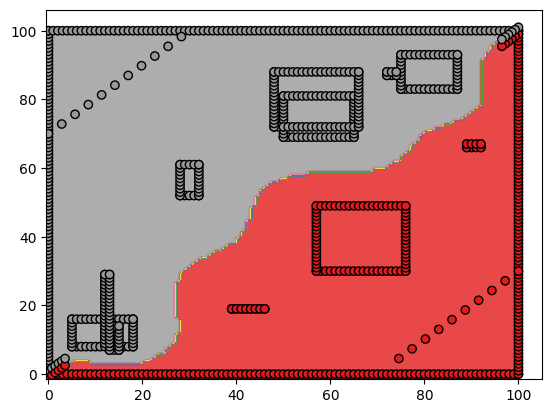

In [ ]:
visualizationSMO(model2, x_train,label)

In [ ]:
# ФУНКЦИЯ ПОДСЧЕТА ДЛИНЫ ТРАЕКТОРИИ

def count_length(modeli,intial,finish):
  iter_inside=0
  napr=np.array([1,1])
  xpoints=np.array([0,0])
  ypoints=np.array([0,0])
  R=5.0 #радиус поиска
  x0=intial[0];y0=intial[1]
  PointCount=1
  while((np.linalg.norm(np.array([x0,y0])- finish))>0.01):#
    if(PointCount>0):
      napr=-1*np.array([xpoints[-2]-xpoints[-1],ypoints[-2]-ypoints[-1] ])
    iter_inside+=1
    if(iter_inside>150):
      break
    minim=100.0
    for j in range(160):
      i=j*np.pi/40
      if(i>=2*np.pi):
        break
      xn=x0+R*np.cos(i)
      yn=y0+R*np.sin(i)
      if(PointCount>0):
        if(np.dot(np.array([xn,yn])-np.array([xpoints[-1],ypoints[-1]]), napr) <-0):
          continue
      dat=pd.DataFrame({'x':[xn],'y':[yn]})
      pred=modeli.predict_proba(dat)[:,0]
      rasn=(abs(pred-0.5))
      if(abs(xn-xpoints[-1])<1 and abs(yn-ypoints[-1])<1):
        continue
      if(rasn<minim):
        minim=rasn
        xnew,ynew=xn,yn
    x0,y0=xnew,ynew
    PointCount+=1
    xpoints=np.append(xpoints,xnew)
    ypoints=np.append(ypoints,ynew)
    if(x0>100 or y0>100):
      break
    if(x0<0 or y0<0):
      break
  return count,xpoints,ypoints



34


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


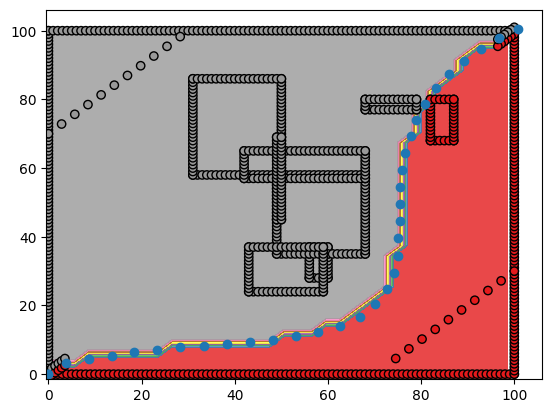

In [ ]:
count,xpoints,ypoints=count_length(rbf_svc,np.array([0,0]),np.array([100,100]))
print(count)
visualization(rbf_svc, visx,visy)
plt.scatter(xpoints,ypoints)

Черновики(не смотреть)
:

:


:

:

:

:

:


:

:

:

:

:
:
:

(1190, 997)


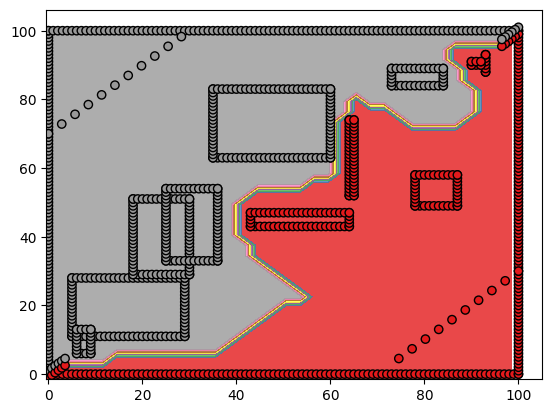

In [ ]:
#plt.figure(figsize=(10,10))
visualization(model, x_train,label)


In [ ]:
# СВОЯ РЕАЛИЗАЦИЯ АЛГОРИТМА SVM ЧЕРЕЗ ГРАДИЕНТНЫЙ СПУСК

class support_vector_machine:
    def __init__(self,C=10,features=2,sigma_sq=0.1,kernel="gaussian"):
        self.C=C
        self.features=features
        self.sigma_sq=sigma_sq
        self.kernel=kernel
        self.weights=np.zeros(features)
        self.bias=0.

    def product(self,x,l): #Аналог скалярного произведения двух векторов
        return np.exp(-sum((x-l)**2)/(2*self.sigma_sq))

    def gaussian_kernel(self,x1,x):
        m=x.shape[0]
        n=x1.shape[0]
        op=np.array([[self.product(x1[x_index],x[l_index]) for l_index in range(m)] for x_index in range(n)])
        print(op.shape)
        #Находит все комбинации скалярных произведений векторов-объектов
        return np.array(op)

    def loss_function(self,y,y_hat):
        sum_terms=1-y*y_hat #y_hat=np.dot(x,self.weights)+self.bias
        sum_terms=np.where(sum_terms<0,0,sum_terms) # Hinge Loss
        return (np.sum(sum_terms)+sum(self.weights**2)/2) # Hinge Loss + L2 регуляризация


    def fit(self,x_train,y_train,epochs=1000,print_every_nth_epoch=100,learning_rate=0.01):
        y=y_train.copy()
        x=x_train.copy()
        self.initial=x.copy()

        x=self.gaussian_kernel(x,x) # Матрица Грамма
        m=x.shape[0]
        self.weights=np.zeros(m)
        n=x.shape[0]

        for epoch in range(epochs):
            y_hat=np.dot(x,self.weights)+self.bias # отступ(margin)
            grad_weights=(-self.C*np.multiply(y,x.T).T+self.weights).T  # Производные по w, х - матрица Грамма

            for weight in range(self.weights.shape[0]):
                grad_weights[weight]=np.where(1-y_hat<=0,self.weights[weight],grad_weights[weight]) # Если отступ(margin) > 1, то учитывается только слагаемое регуляризации

            grad_weights=np.sum(grad_weights,axis=1)
            self.weights-=learning_rate*grad_weights/n # Градиентный спуск
            grad_bias=-y*self.bias
            grad_bias=np.where(1-y_hat<=0,0,grad_bias)
            grad_bias=sum(grad_bias)
            self.bias-=grad_bias*learning_rate/n  # Градиентный спуск для bias
            # if((epoch+1)%print_every_nth_epoch==0):
            #     print("--------------- Epoch {} --> Loss = {} ---------------".format(epoch+1, self.loss_function(y,y_hat)))

    def evaluate(self,x,y): # Проверка насколько хорошо работает на x_train
        pred=self.predict(x)
        pred=np.where(pred==-1,0,1)
        diff=np.abs(np.where(y==-1,0,1)-pred)
        return((len(diff)-sum(diff))/len(diff)) #sum(diff) - количество ошибок классификации. Возвращает долю верных классификаций

    def predict(self,x):
        if(self.kernel=="gaussian"):
            x=self.gaussian_kernel(x,self.initial) #self.initial - x_train
        return np.where(np.dot(x,self.weights)+self.bias>0,1,-1) # Возвращает знаки проекции векторов на нормаль(w)

In [ ]:
# SVM с градиентным спуском
model=support_vector_machine(C=1.0,sigma_sq=0.5)
model.fit(np.array(x_train),label,epochs=10,print_every_nth_epoch=10,learning_rate=0.1)
print("Training Accuracy = {}".format(model.evaluate(np.array(x_train),label)))

(947, 947)
(947, 947)
Training Accuracy = 1.0
(1190, 947)


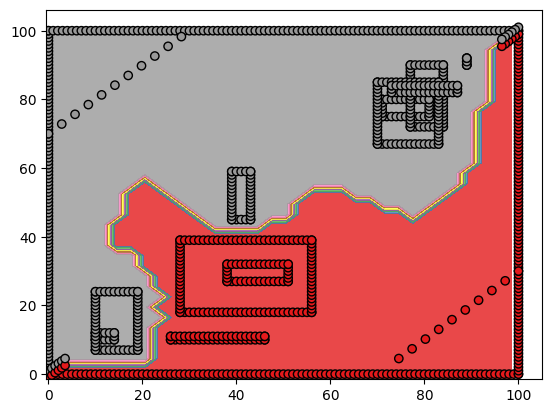

In [ ]:
# SVM с градиентным спуском
model=support_vector_machine(C=1.0,sigma_sq=0.5)
model.fit(np.array(x_train),label,epochs=10,print_every_nth_epoch=10,learning_rate=0.1)
print("Training Accuracy = {}".format(model.evaluate(np.array(x_train),label)))
#plt.figure(figsize=(10,10))
visualization(model, x_train,label)

In [ ]:
model22=Cvxpy(x_train)
#labelcp=np.where(label==-1,0,1)
#print(labelcp)
model22.fit(x_train,label)

997 997
(997, 997)
optimal
[8.98870678e-07 8.98870721e-07 8.98870781e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-

In [ ]:
print(model22.predict(x_train))
#print(np.where(model22.predict(x_train)>0,1,-1))
print(accuracy_score(label,model22.predict(x_train)))

W=  [8.98870678e-07 8.98870721e-07 8.98870781e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98870791e-07 8.98870791e-07 8.98870791e-07
 8.98870791e-07 8.98

In [ ]:
#SVXPY не работает

import cvxpy as cp

class Cvxpy:
  def __init__(self,X,C=10):
    self.C=C
    n,m=X.shape
    self.W=cp.Variable(n)
    self.b=cp.Variable()
    self.sigma_sq=0.1

  def product(self,k,l): #Аналог скалярного произведения двух векторов
      return np.exp(-sum((k-l)**2)/(2*self.sigma_sq))

  def gaussian_kernel(self,x1,x2):
        m1=x2.shape[0]
        n1=x1.shape[0]
        print(m1,n1)
        op=np.array([[self.product(x1[x_index],x2[l_index]) for l_index in range(m1)] for x_index in range(n1)])
        print(op.shape)
        #Находит все комбинации скалярных произведений векторов-объектов
        return op

  def fit(self,X,Y):
    y=np.copy(Y)
    x=np.copy(X)
    self.initial=np.copy(x)

    x=self.gaussian_kernel(x,x)
    m,n=x.shape
    self.W=cp.Variable(n)
    self.b=cp.Variable()
    Psi=cp.Variable(m)

    # loss = cp.sum(cp.pos(1 - cp.multiply(Y, x @ self.W - b)))
    # print("loss ",loss)
    # reg = cp.norm(self.W, 1)
    # #lambd = cp.Parameter(nonneg=True)
    # prob = cp.Problem(cp.Minimize(loss + reg))
    # prob.solve()





    objective=cp.Minimize(0.5*cp.square(cp.norm(self.W))+self.C*cp.sum(Psi))

    ##cp.sum(cp.multiply(y, cp.matmul(X, alpha) + b)) >= 1 - xi
    #constraints=[cp.sum(cp.multiply(y,cp.matmul(x,(self.W))+self.b))-1+Psi>=0,Psi>=0]

    constraints=[cp.sum(cp.multiply(y,x@self.W)+self.b)-1+Psi>=0,Psi>=0,0 <= self.W, self.W <= self.C]


    prob=cp.Problem(objective,constraints)
    prob.solve()
    print(prob.status)
    print(self.W.value,self.b.value)

  def predict(self,x_train):
    #decision_function = x @ (self.gaussian_kernel(x,self.initial)).T @ self.W + self.b
    #return np.sign(decision_function)

    print("W= ",self.W.value)
    print("b= ",self.b.value)

    X=np.copy(x_train)

    print(self.initial.shape, X.shape)

    x=self.gaussian_kernel(X,self.initial) #self.initial - x_train
    print('here')
    prediction = (np.dot(x, self.W.value)) + self.b.value
    return np.where(prediction > 0, 1, -1)
    #return np.where(np.dot(x,self.W.numpy())+self.b>0,1,-1) # Возвращает знаки проекции векторов на нормаль(w)


In [ ]:
def gl(X,Y,number):
  global koef,b
  x_train=np.array([])
  y_train=np.array([])
  label=np.array([])
  change=np.array([0]*len(np.unique(number)))

  for i in np.unique(number):

    center_mass=np.array([X[number==i].mean(),Y[number==i].mean()])
    x_train=np.append(x_train,X[number==i])
    y_train=np.append(y_train,Y[number==i])
    if(koef*center_mass[0]- center_mass[1]+b >=0):
      print("da")
      labe=np.full(len(X[number==i]),-1)
      label=np.append(label,labe)

    else:
      print("net")
      labe=np.full(len(X[number==i]),1)
      label=np.append(label,labe)
  zapusk(x_train,y_train,label)

  label_change=np.copy(label)
  for i in np.unique(number):
    center_mass=np.array([X[number==i].mean(),Y[number==i].mean()])
    #x_train=np.append(x_train,X[number==i])
    #y_train=np.append(y_train,Y[number==i])
    if(koef*center_mass[0]- center_mass[1]+b >=0):
      if(X[number==i].min()*koef-Y[number==i].min()+b <=0):
        labe=np.full(len(X[number==i]),1)
        label_change=np.hstack(labe,label[X[number!=i]])

        zapusk(x_train,y_train,label_change)
        change[i]=1

    else:
      if(X[number==i].max()*koef-Y[number==i].max()+b >=0):
        labe=np.full(len(X[number==i]),1)
        label_change=np.hstack(labe,label[X[number!=i]])

        zapusk(x_train,y_train,label_change)
        change[i]=1
        for k in range(i):
          if(change[k]):



x_train,y_train,labe=gl(X,Y,number)
#print(x_train.shape,y_train.shape,number.shape)
Xt=np.hstack([ x_bord,xp, x0,x_train])
Yt=np.hstack([ y_bord,yp, y0,y_train])
label=np.hstack([label_bord,labelp,label0,labe])
#print(Xt.shape,Yt.shape,label.shape)

x_train=pd.DataFrame({'x':Xt,'y':Yt})
#print(x_train.shape)

#Библиотека
rbf_svc = svm.SVC(kernel='rbf', C=12,  probability=True).fit(x_train, label)
print('Accuracy of RBF kernel:', accuracy_score(label, rbf_svc.predict(x_train)))

# SVM с градиентным спуском
model=support_vector_machine(C=1.0,sigma_sq=0.5)
model.fit(np.array(x_train),label,epochs=10,print_every_nth_epoch=10,learning_rate=0.1)
print("Training Accuracy = {}".format(model.evaluate(np.array(x_train),label)))

#SMO
#model_smo=svm_smo()
#sv=model_smo.fit(np.array(x_train),label)
#print('Accuracy of RBF kernel:', model_smo.evaluate(np.array(x_train), np.array(label)))


da
net
net
net
da
net
da
Accuracy of RBF kernel: 0.9876543209876543
Training Accuracy = 1.0


In [ ]:
# СВОЯ РЕАЛИЗАЦИЯ  SVM  ЧЕРЕЗ SMO
class svm_smo:
  def __init__(self,max_iter=5,C=5.0,eps=0.1):
    self.max_iter=max_iter
    self.eps=eps
    self.C=C
    self.w=None
    self.b=None
  def kernel(self, x1,x2):
    return math.exp((np.linalg.norm(x1-x2)**2)/(-1))
  def get_random_int(self,a,b,z):
    r=list(range(a,z))+list(range(z+1,b))
    return random.choice(r)
  def calc_w(self,x,y,alfa):
    x=self.gaussian_kernel(x,self.initial)
    return np.dot(x.T, np.multiply(alfa,y))
  def calc_b(self, x, y,w):
    x=self.gaussian_kernel(x,self.initial)
    return np.mean(y-np.dot(x,w))
  def E(self,x_k,y_k,w,b):
    x_k=self.gaussian_kernel(x_k,self.initial)
    return np.sign(np.dot(x_k,w)+b)-y_k
  def compute_L_H(self,C, alfa_prime_j, alfa_prime_i, y_j, y_i):
    if y_i != y_j:
      return max(0, alfa_prime_j -alfa_prime_i), min(C, C - alfa_prime_i+alfa_prime_j)
    else:
      return max(0, alfa_prime_i+alfa_prime_j-C), min(C,alfa_prime_i+alfa_prime_j)
  def gaussian_kernel(self,x1,x):
        m=x.shape[0]
        n=x1.shape[0]
        op=[[self.kernel(x1[x_index],x[l_index]) for l_index in range(m)] for x_index in range(n)]
        #Находит все комбинации скалярных произведений векторов-объектов
        return np.array(op)
  def fit(self, x,y):
    n,d = x.shape
    alfa=np.zeros((n))
    self.initial=np.copy(x)
    for iter in range(self.max_iter):
      alfa_prev=np.copy(alfa)
      for j in range(0,n):
        i=self.get_random_int(0,n-1,j)
        kij=self.kernel(x[i],x[i])+self.kernel(x[j],x[j])-2*self.kernel(x[i],x[j])
        if kij <=0:
          continue
        alfa_prime_i,alfa_prime_j=alfa[i],alfa[j]
        L,H=self.compute_L_H(self.C,alfa_prime_j,alfa_prime_i, y[j],y[i])
        self.w=self.calc_w(x,y,alfa)
        self.b=self.calc_b(x,y,self.w)
        E_i=self.E(x[i],y[i], self.w,self.b)
        E_j=self.E(x[j],y[j],self.w,self.b)
        alfa[j]=np.mean(alfa_prime_j+(y[j]*(E_i-E_j))/kij)

        alfa[j]=max(alfa[j],L)
        alfa[j]=min(alfa[j],H)

        alfa[i]=alfa_prime_i+y[i]*y[j]*(alfa_prime_j-alfa[j])
      diff=np.linalg.norm(alfa-alfa_prev)
      if(diff<self.eps):
        break
    self.w=self.calc_w(x,y,alfa)
    self.b=self.calc_b(x,y,self.w)

    idx=np.where(alfa>0)[0]
    sv=x[idx]
    return sv
  def predict(self, x):
    x=self.gaussian_kernel(x,self.initial)
    return np.where(np.dot(x,self.w)+self.b>0,1,-1)
  def evaluate(self,x,y): # Проверка насколько хорошо работает на x_train
        pred=self.predict(x)
        pred=np.where(pred==-1,0,1)
        diff=np.abs(np.where(y==-1,0,1)-pred)
        return((len(diff)-sum(diff))/len(diff))
  def accuracy(self, x,y):
    cor=self.predict(x)==y
    acc=sum(cor)/len(y)
    return acc




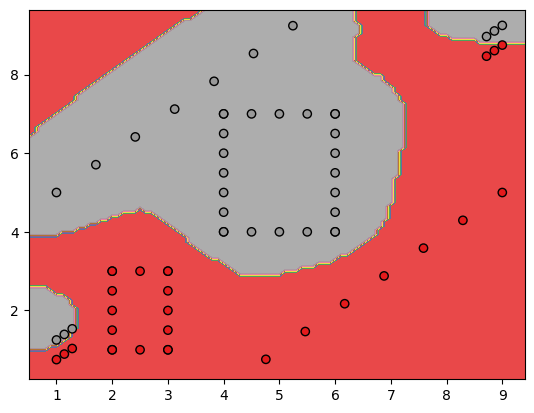

In [ ]:
X=np.array(x_train)
y=y_train
h = 0.1  # шаг в сетке

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Создаем график
#plt.figure(figsize=(12, 8))

# Рисуем границы принятия решений на графике

Z = model_smo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Set1, alpha=0.8)

# Рисуем точки данных
plt.scatter(X[:, 0], X[:, 1], c=y,cmap=plt.cm.Set1,  edgecolor='k')

In [ ]:


class another_SVM:
    def __init__(self, C=1.0, tol=1e-3, max_iter=100, gamma=0.1):
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.gamma = gamma
     # Kernel function (RBF kernel)
    def kernel(x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize alpha vector and bias term
        self.alpha = np.zeros(n_samples)
        self.bias = 0.0
        # SMO algorithm with RBF kernel
        for _ in range(self.max_iter):
            num_changed_alphas = 0
            for i in range(n_samples):
                Ei = np.dot(self.alpha * y, [y[j] * self.kernel(X[i], X[j]) for j in range(n_samples)]) + self.bias - y[i]
                if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or (y[i]*Ei > self.tol and self.alpha[i] > 0):
                    j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                    Ej = np.dot(self.alpha * y, [y[idx] * self.kernel(X[j], X[idx]) for idx in range(n_samples)]) + self.bias - y[j]
                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]
                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    eta = 2 * self.kernel(X[i], X[j]) - self.kernel(X[i], X[i]) - self.kernel(X[j], X[j])
                    if eta >= 0:
                        continue
                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = max(L, min(H, self.alpha[j]))
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.bias - Ei - y[i] * (self.alpha[i] - alpha_i_old) * self.kernel(X[i], X[i]) - y[j] * (self.alpha[j] - alpha_j_old) * self.kernel(X[i], X[j])
                    b2 = self.bias - Ej - y[i] * (self.alpha[i] - alpha_i_old) * self.kernel(X[i], X[j]) - y[j] * (self.alpha[j] - alpha_j_old) * self.kernel(X[j], X[j])

                    if 0 < self.alpha[i] < self.C:
                        self.bias = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.bias = b2
                    else:
                        self.bias = (b1 + b2) / 2
                    num_changed_alphas += 1
            if num_changed_alphas == 0:
                break
    def predict(self, X):
        return np.sign(np.dot(self.alpha * y, [y[idx] * self.kernel(x, X) for idx, x in enumerate(X)]) + self.bias)


svm_rbf = another_SVM(C=1.0, gamma=0.1)
svm_rbf.fit(x_train, label)
prediction = svm_rbf.predict(x_train)
print("Prediction for test input:", accuracy_score(prediction-label))


KeyError: 0

guide_vector  [0.70710678 0.70710678]


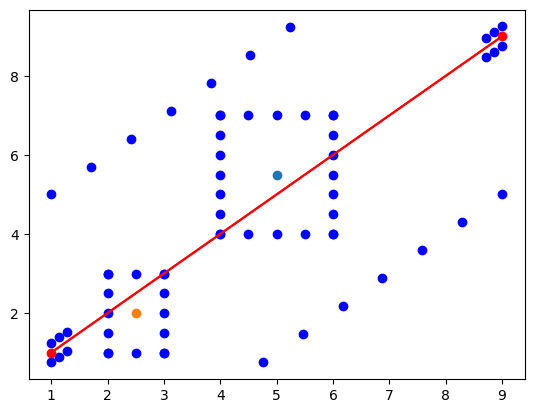

In [ ]:
# РУЧНОЕ ЗАДАНИЕ ПРЕПЯТСТВИЙ
def give_label(c,n): # Присваивает препятствию метку -1 или 1 в зависмости от положения центра масс
  global k,b
  if(k*c[0]- c[1]+b >=0):
    label=np.full(n,-1)
  else:
    label=np.full(n,1)
  return label


length=10
width=10
intial=np.array([1,1]) # начальная точка
finish=np.array([9,9]) # конечная точка
k=(finish[1]-intial[1])/(finish[0]-intial[0])
b=intial[1]-k*intial[0]
guide_vector=(finish-intial)/np.linalg.norm(finish-intial) # вектор коллиниарный прямой соединяющий начал. и конеч. точки
print('guide_vector ', guide_vector)



#Точки вокруг начальной и конечной точек
x0,y0=[intial[0],intial[0],finish[0],finish[0]],[intial[1],intial[1],finish[1],finish[1]]
y0[0]-=0.25
y0[1]+=0.25
y0[2]-=0.25
y0[3]+=0.25
label0=[-1,1,-1,1]
step=0.2
n=2 #количество искусственных точек сверху и снизу вокруг начал. и конеч. точек
for i in range(4*n):
  x0.append(x0[i]+((-1)**(i%4 >=2))*step*guide_vector[0])
  y0.append(y0[i]+((-1)**(i%4 >=2))*step*guide_vector[1])
  label0.append((-1)**(i%2 ==0))

plt.scatter(x0,y0,c='blue')

#Границы "Параллельные прямые"
xp,yp=[intial[0]],[intial[1]+4]
step2=1
counter=0
labelp=[1]
for i in range(0,10,1):
  counter+=1
  xp.append(xp[i]+step2*guide_vector[0])
  yp.append(yp[i]+step2*guide_vector[1])
  labelp.append(1)
  if((xp[-1]>(finish[0])) or (yp[-1]>(finish[1]))):
    break
xp.append(finish[0])
yp.append(finish[1]-4)
labelp.append(-1)
for i in range(counter+1,counter+10,1):
  xp.append(xp[i]-step2*guide_vector[0])
  yp.append(yp[i]-step2*guide_vector[1])
  labelp.append(-1)
  if(xp[-1]<(intial[0]) or yp[-1]<(intial[1])):
    break
#(xp[-1]<finish[0] and yp[-1]<finish[1]):

plt.scatter(xp,yp, c='blue')

#Границы "квадрат"
bord=np.arange(0,10.1,0.5)
x_bord=np.hstack([bord,np.zeros(len(bord)),np.full(len(bord),10),bord])
y_bord=np.hstack([np.zeros(len(bord)),bord,bord,np.full(len(bord),10)])
lb=[]
for i in range(len(x_bord)):
  if(x_bord[i] < y_bord[i]):
    lb.append(1)
  else:
    lb.append(-1)
label_bord=np.array(lb)
#plt.scatter(x_bord,y_bord,c='blue')

# Начальная и конечная точки
plt.scatter(intial[0],intial[1], c='red')
plt.scatter(finish[0],finish[1], c='red')
plt.plot([intial[0],finish[0]],[intial[1],finish[1]], c='red')

# Препятствия
obstx=np.arange(4,6.1,0.5)
obsty=np.arange(4,7.1,0.5)
X=np.hstack([obstx,np.full(len(obsty),int(obstx[0])),np.full(len(obsty),int(obstx[-1])),obstx])
Y=np.hstack([np.full(len(obstx),int(obsty[0])),obsty,obsty,np.full(len(obstx),int(obsty[-1]))])

plt.scatter(X,Y,c='blue')

obstx1=np.arange(2,3.1,0.5)
obsty1=np.arange(1,3.1,0.5)
X1=np.hstack([obstx1,np.full(len(obsty1),int(obstx1[0])),np.full(len(obsty1),int(obstx1[-1])),obstx1])
Y1=np.hstack([np.full(len(obstx1),int(obsty1[0])),obsty1,obsty1,np.full(len(obstx1),int(obsty1[-1]))])
label1=np.full(len(X),-1)
plt.scatter(X1,Y1,c='blue')

# Центр масс
c=[X.mean(), Y.mean()]
c1=[X1.mean(), Y1.mean()]
plt.scatter(c[0], c[1])
plt.scatter(c1[0], c1[1])
label=give_label(c,len(X))
label1=give_label(c1,len(X1))

plt.plot([intial[0],finish[0]],[intial[1],finish[1]], c='red')

In [ ]:
X=np.hstack([ xp, x0,X,X1])
Y=np.hstack([ yp, y0,Y, Y1])

label=np.hstack([labelp,label0,label, label1])
x_train = pd.DataFrame({'x':X,'y':Y, 'obst':label})
x_train

,x,y,obst
0,1.000000,5.000000,1
1,1.707107,5.707107,1
2,2.414214,6.414214,1
3,3.121320,7.121320,1
4,3.828427,7.828427,1
...,...,...,...
61,3.000000,2.500000,-1
62,3.000000,3.000000,-1
63,2.000000,3.000000,-1
64,2.500000,3.000000,-1


In [ ]:
# ЗАПУСК НА СВОЕЙ РЕАЛИЗАЦИИ SWM

start=time.time()
model=support_vector_machine(C=1.0,sigma_sq=0.1)
model.fit(np.array(x_train),y_train,epochs=100,print_every_nth_epoch=10,learning_rate=0.01)
finish=time.time()
res2=(finish-start)*1000 # Время работы в милисекундах

print("Training Accuracy = {}".format(model.evaluate(np.array(x_train),y_train)))
print(res2)

Training Accuracy = 1.0
96.41623497009277
